# Part 1 - Introduction

Brazil’s President Bolsanaro was viewed internationally as a proponent of Amazon’s deforestation to grow his country’s economy. Over his term, the average size of deforested patches grew by 61%, and total deforested lands averaged 11,000 square kilometres per year.

When Bolsonaro came into power, an active deforestation policy was put into action. Citizens were encouraged by Bolsonaro, through speeches, to burn their own land to make room for economic activities (farming, cattle…).

We are interested in the impact of Bolsonaro’s diffusion of political rhetoric on deforestation rates in local communities. We will specifically look at whether the effects were more pronounced in communities where local radio was used to divulge information. 


# Part 2 - Data cleanup

We obtained the deforestation data from PRODES a satellite monitoring project of clear-cut deforestation in the Legal Amazon region used by the Brazilian government to establish public policies. We got state level forest fires from the Brazilian government's 'Programa Queimadas'. Also, we got the media-reach variable form the 2010 census and municipality GDP and value added from Brazil's statistical institute (IBGE)

We divided the cleaning into three sections: 
1. Part number one involves state level data (deforestation and forest fires) we are going to use this dataset to create graphs rather than utilize it in our regression. 
2. The second part involves cleaning our municipal-level data which includes deforestated area, GDP and value added variables apart from the index variables (municipality, geo-code and year). 
3. The third part will be produced in R. Because we intend to produce maps with the data collected, using R is the logical choice as a package already exists with geo-location data in state and municipal level for Brazil, making it much easier to code maps. 

In [450]:
import pandas as pd
import numpy as np

%matplotlib inline

### Data Cleaning - Part A:
We will first start cleaning the deforestation data for state level 

In [451]:
deforestation = pd.read_csv('deforestation.csv')
print(deforestation)

           year;area km²;uf
2022;27        00;Tocantins
2022;240         00;Roraima
2022;1.512      00;Rondônia
2022;4.141          00;Pará
2022;1.906   00;Mato Grosso
...                     ...
1988;5.140   00;Mato Grosso
1988;2.450      00;Maranhão
1988;60            00;Amapá
1988;1.510      00;Amazonas
1988;620            00;Acre

[315 rows x 1 columns]


Python is not able to separate the data by its delimiter (;) thus, all the variables are stored in one column. We will split the data using the semicolon as the delimiter

In [452]:
deforestation = deforestation["year;area km²;uf"].str.split(';', expand = True)
deforestation = deforestation.reset_index()
deforestation = deforestation.rename(columns={ 1: 'state'})
deforestation

,index,0,state
0,2022;27,00,Tocantins
1,2022;240,00,Roraima
2,2022;1.512,00,Rondônia
3,2022;4.141,00,Pará
4,2022;1.906,00,Mato Grosso
...,...,...,...
310,1988;5.140,00,Mato Grosso
311,1988;2.450,00,Maranhão
312,1988;60,00,Amapá
313,1988;1.510,00,Amazonas


The index column still stores the year and area columns into one so we will split that specific column and store it as index1 dataframe. Then we will merge both datasets together based on their observation number, keep the variables year, state and area as the new deforestation dataframe and index the variable year. 

In [453]:
index1 = deforestation["index"].str.split(';', expand = True)
index1 = index1.rename(columns={0: 'year', 1: 'area_deforested'})
deforestation = pd.concat([index1, deforestation], axis=1)
vars = ['year', 'area_deforested', 'state']
deforestation = deforestation[vars]
deforestation = deforestation.set_index('year')

Brazil has a different decimal system (they use a dot(.) when they refer to thousands and a comma (.) to indicate decimal points. The area variable we kept has dots which python considers to be demical points when in fact our column only consists of integers. 

In [454]:
deforestation["area_deforested"] = deforestation["area_deforested"].astype(str)

In [455]:
decimal = deforestation["area_deforested"].str.split('.', expand = True)

In [456]:
decimal[0] = decimal[0].astype(int)
decimal[1] = decimal[1].fillna(0)
decimal[1] = decimal[1].astype(int)

In [457]:
def multiply(s):
    if s < 10:
        out = s*1000
    else:
        out = s

    return out

In [458]:
decimal[0] = decimal[0].apply(multiply)
decimal[0] = decimal[0]+decimal[1]
decimal = decimal[0]

In [459]:
deforestation = pd.concat([decimal, deforestation], axis=1)
vars2 = [0,'state']
deforestation = deforestation[vars2]
deforestation = deforestation.rename(columns={0: 'area_deforested'})
deforestation

,area_deforested,state
year,,
2022,27,Tocantins
2022,240,Roraima
2022,1512,Rondônia
2022,4141,Pará
2022,1906,Mato Grosso
...,...,...
1988,5140,Mato Grosso
1988,2450,Maranhão
1988,60,Amapá


Once the decimal points are fixed, we will convert the variable years to datetime but only keep the year part of the datetime.

In [460]:
deforestation = deforestation.reset_index()
deforestation['year'] = pd.to_datetime(deforestation['year'])

In [461]:
deforestation["year"] = deforestation["year"].dt.year

In [462]:
deforestation = deforestation.set_index('year')

In [463]:
print(deforestation)

      area_deforested        state
year                              
2022               27    Tocantins
2022              240      Roraima
2022             1512     Rondônia
2022             4141         Pará
2022             1906  Mato Grosso
...               ...          ...
1988             5140  Mato Grosso
1988             2450     Maranhão
1988               60        Amapá
1988             1510     Amazonas
1988              620         Acre

[315 rows x 2 columns]


The state-level deforestation data is now cleaned. We need to merge it with the forest fire dataset.
The historical forest fire data is stored per State. Therfore, there is one dataframe (with indentical structure) for each state 

In [464]:
Qacre = pd.read_csv('historico_estado_acre.csv')
Qacre

,Unnamed: 0,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro,Total
0,1998,-,-,-,-,-,3,35,131,512,44,-,7,732
1,1999,-,-,-,-,-,-,1,67,212,63,4,-,347
2,2000,-,-,11,1,1,1,1,136,261,18,-,-,430
3,2001,-,-,-,-,-,1,3,399,288,137,1,-,829
4,2002,-,1,-,-,-,-,59,1268,4337,932,139,3,6739
5,2003,14,-,-,5,18,18,427,3163,5803,1041,30,4,10523
6,2004,-,4,-,9,21,12,95,1003,5458,633,25,11,7271
7,2005,20,-,5,2,17,75,1136,7669,6092,943,27,7,15993
8,2006,7,1,-,2,58,34,186,1507,3737,600,66,-,6198
9,2007,1,14,5,8,15,76,181,1942,5446,823,38,-,8549


We will only keep the total annual variable and the year index. We need to rename the variables, drop the last three rows. Create a new variable that stores which state the row is refering to and use the year column as index. We repeated this process for every state.

In [465]:
vars1 = ['Unnamed: 0', 'Total']
Qacre = Qacre[vars1]
Qacre = Qacre.rename(columns={'Unnamed: 0': 'year', 'Total': 'total_fires'})
Qacre = Qacre.iloc[:-3 , :]
Qacre['state'] = 'Acre'
Qacre['year'] = pd.to_datetime(Qacre['year'])
Qacre["year"] = Qacre["year"].dt.year
Qacre = Qacre.set_index('year')

In [466]:
Qamapa = pd.read_csv('historico_estado_amapa.csv')
Qamapa = Qamapa[vars1]
Qamapa = Qamapa.rename(columns={'Unnamed: 0': 'year', 'Total': 'total_fires'})
Qamapa = Qamapa.iloc[:-3 , :]
Qamapa['state'] = 'Amapá'
Qamapa['year'] = pd.to_datetime(Qamapa['year'])
Qamapa["year"] = Qamapa["year"].dt.year
Qamapa = Qamapa.set_index('year')

In [467]:
Qamazonas = pd.read_csv('historico_estado_amazonas.csv')
Qamazonas = Qamazonas[vars1]
Qamazonas = Qamazonas.rename(columns={'Unnamed: 0': 'year', 'Total': 'total_fires'})
Qamazonas = Qamazonas.iloc[:-3 , :]
Qamazonas['state'] = 'Amazonas'
Qamazonas['year'] = pd.to_datetime(Qamazonas['year'])
Qamazonas["year"] = Qamazonas["year"].dt.year
Qamazonas = Qamazonas.set_index('year')

In [468]:
Qmaranhao = pd.read_csv('historico_estado_maranhao.csv')
Qmaranhao = Qmaranhao[vars1]
Qmaranhao = Qmaranhao.rename(columns={'Unnamed: 0': 'year', 'Total': 'total_fires'})
Qmaranhao = Qmaranhao.iloc[:-3 , :]
Qmaranhao['state'] = 'Maranhão'
Qmaranhao['year'] = pd.to_datetime(Qmaranhao['year'])
Qmaranhao["year"] = Qmaranhao["year"].dt.year
Qmaranhao = Qmaranhao.set_index('year')

In [469]:
Qmato = pd.read_csv('historico_estado_mato_grosso.csv')
Qmato = Qmato[vars1]
Qmato = Qmato.rename(columns={'Unnamed: 0': 'year', 'Total': 'total_fires'})
Qmato = Qmato.iloc[:-3 , :]
Qmato['state'] = 'Mato Grosso'
Qmato['year'] = pd.to_datetime(Qmato['year'])
Qmato["year"] = Qmato["year"].dt.year
Qmato = Qmato.set_index('year')

In [470]:
Qpara = pd.read_csv('historico_estado_para.csv')
Qpara = Qpara[vars1]
Qpara = Qpara.rename(columns={'Unnamed: 0': 'year', 'Total': 'total_fires'})
Qpara = Qpara.iloc[:-3 , :]
Qpara['state'] = 'Pará'
Qpara['year'] = pd.to_datetime(Qpara['year'])
Qpara["year"] = Qpara["year"].dt.year
Qpara = Qpara.set_index('year')

In [471]:
Qrondonia = pd.read_csv('historico_estado_rondonia.csv')
Qrondonia = Qrondonia[vars1]
Qrondonia = Qrondonia.rename(columns={'Unnamed: 0': 'year', 'Total': 'total_fires'})
Qrondonia = Qrondonia.iloc[:-3 , :]
Qrondonia['state'] = 'Rondônia'
Qrondonia['year'] = pd.to_datetime(Qrondonia['year'])
Qrondonia["year"] = Qrondonia["year"].dt.year
Qrondonia = Qrondonia.set_index('year')

In [472]:
Qroraima = pd.read_csv('historico_estado_roraima.csv')
Qroraima = Qroraima[vars1]
Qroraima = Qroraima.rename(columns={'Unnamed: 0': 'year', 'Total': 'total_fires'})
Qroraima = Qroraima.iloc[:-3 , :]
Qroraima['state'] = 'Roraima'
Qroraima['year'] = pd.to_datetime(Qroraima['year'])
Qroraima["year"] = Qroraima["year"].dt.year
Qroraima = Qroraima.set_index('year')

In [473]:
Qtocantins = pd.read_csv('historico_estado_tocantins.csv')
Qtocantins = Qtocantins[vars1]
Qtocantins = Qtocantins.rename(columns={'Unnamed: 0': 'year', 'Total': 'total_fires'})
Qtocantins = Qtocantins.iloc[:-3 , :]
Qtocantins['state'] = 'Tocantins'
Qtocantins['year'] = pd.to_datetime(Qtocantins['year'])
Qtocantins["year"] = Qtocantins["year"].dt.year
Qtocantins = Qtocantins.set_index('year')

Once all the dataframes of the states were clean we merged them vertically to create the queimadas (forest fires) dataframe which we then merged with the deforestation dtataframe horizontally.

In [474]:
frames = [Qacre, Qamapa,Qamazonas,Qmaranhao,Qmato,Qpara, Qrondonia, Qroraima, Qtocantins]
queimadas = pd.concat(frames)
queimadas

,total_fires,state
year,,
1998,732,Acre
1999,347,Acre
2000,430,Acre
2001,829,Acre
2002,6739,Acre
...,...,...
2018,8033,Tocantins
2019,13625,Tocantins
2020,12093,Tocantins


In [475]:
environmental = pd.merge(queimadas, deforestation, on=["year",'state'])
environmental

,total_fires,state,area_deforested
year,,,
1998,732,Acre,536
1999,347,Acre,441
2000,430,Acre,547
2001,829,Acre,419
2002,6739,Acre,883
...,...,...,...
2018,8033,Tocantins,25
2019,13625,Tocantins,23
2020,12093,Tocantins,25


In [476]:
environmental = environmental.reset_index()

In [477]:
environmental["Bolsonaro"] = np.where(environmental['year']>2018, 1, 0)
environmental

,year,total_fires,state,area_deforested,Bolsonaro
0,1998,732,Acre,536,0
1,1999,347,Acre,441,0
2,2000,430,Acre,547,0
3,2001,829,Acre,419,0
4,2002,6739,Acre,883,0
...,...,...,...,...,...
220,2018,8033,Tocantins,25,0
221,2019,13625,Tocantins,23,1
222,2020,12093,Tocantins,25,1
223,2021,10007,Tocantins,37,1


In [478]:
environmental = environmental.set_index("year")

In [479]:
environmental.to_csv('environ_stateFINAL.csv')

### Data Cleaning - Part B:
#### Radio reach variable cleanup:

In [480]:
radiom = pd.read_excel(r'radio_municipalidad.xlsx', sheet_name='Tabela 1')
print(radiom)

     Tabela 2249 - Domicílios particulares permanentes, por alguns bens duráveis existentes no domicílio - Resultados Gerais da Amostra Variável - Domicílios particulares permanentes  \
0        Variável - Domicílios particulares permanentes                                                                                                                                  
1                                                 Nível                                                                                                                                  
2                                                   NaN                                                                                                                                  
3                                                 Nível                                                                                                                                  
4                                                    MU               

In [481]:
radiom.rename(columns={"Tabela 2249 - Domicílios particulares permanentes, por alguns bens duráveis existentes no domicílio - Resultados Gerais da Amostra Variável - Domicílios particulares permanentes": "Level", 'Unnamed: 1':'geo_code', 'Unnamed: 2':'Municipality', 'Unnamed: 3': 'State', 'Unnamed: 4': 'Total', 'Unnamed: 5': 'Units', 'Unnamed: 6': 'Radio', 'Unnamed: 7': 'Units', 'Unnamed: 8': 'TV', 'Unnamed: 9': 'Units'}, inplace = True)
radiom = radiom[-5566:]
radiom = radiom.iloc[:-1 , :]
print(radiom)

     Level geo_code            Municipality State   Total     Units   Radio  \
4       MU  1100015  Alta Floresta D'Oeste     RO    7274  Unidades    5526   
5       MU  1100023              Ariquemes     RO   27190  Unidades   17399   
6       MU  1100031                 Cabixi     RO    1974  Unidades    1633   
7       MU  1100049                 Cacoal     RO   24196  Unidades   17176   
8       MU  1100056             Cerejeiras     RO    5341  Unidades    3911   
...    ...      ...                     ...   ...     ...       ...     ...   
5564    MU  5222005             Vianópolis     GO    3991  Unidades    3186   
5565    MU  5222054         Vicentinópolis     GO    2352  Unidades    1690   
5566    MU  5222203               Vila Boa     GO    1401  Unidades     962   
5567    MU  5222302          Vila Propício     GO    1472  Unidades    1121   
5568    MU  5300108               Brasília     DF  774037  Unidades  628036   

         Units      TV     Units  
4     Unidades  

The radio level column is household samples that own a radio. Therefore we created a new variable called `radio_rate` that is the percentage of homes censused that owned radios per municipality.

In [482]:
radiom['radio_rate'] = radiom.apply(lambda row: 100*(row.Radio / row.Total), axis=1)
radiom['TV_rate'] = radiom.apply(lambda row: 100*(row.TV / row.Total), axis=1)
var = ["geo_code", "Municipality", "State", "radio_rate", "TV_rate"]
radiom = radiom[var]
radiom

,geo_code,Municipality,State,radio_rate,TV_rate
4,1100015,Alta Floresta D'Oeste,RO,75.969205,83.145450
5,1100023,Ariquemes,RO,63.990438,91.129092
6,1100031,Cabixi,RO,82.725431,87.892604
7,1100049,Cacoal,RO,70.986940,93.457596
8,1100056,Cerejeiras,RO,73.225988,91.200150
...,...,...,...,...,...
5564,5222005,Vianópolis,GO,79.829617,96.316713
5565,5222054,Vicentinópolis,GO,71.853741,93.027211
5566,5222203,Vila Boa,GO,68.665239,93.361884
5567,5222302,Vila Propício,GO,76.154891,87.364130


In [483]:
radiom = radiom.set_index("geo_code")
print(radiom)

                    Municipality State  radio_rate    TV_rate
geo_code                                                     
1100015   Alta Floresta D'Oeste     RO   75.969205  83.145450
1100023               Ariquemes     RO   63.990438  91.129092
1100031                  Cabixi     RO   82.725431  87.892604
1100049                  Cacoal     RO   70.986940  93.457596
1100056              Cerejeiras     RO   73.225988  91.200150
...                          ...   ...         ...        ...
5222005              Vianópolis     GO   79.829617  96.316713
5222054          Vicentinópolis     GO   71.853741  93.027211
5222203                Vila Boa     GO   68.665239  93.361884
5222302           Vila Propício     GO   76.154891  87.364130
5300108                Brasília     DF   81.137723  98.194143

[5565 rows x 4 columns]


In [484]:
radiom.to_csv('radiomuniclean.csv')

Once we index geo_code we only safed radio_rate in radio and that is the dataframe we will merge with the deforestation and GDP data 

In [485]:
radio = radiom[["radio_rate"]]
radio = radio.reset_index()

#### Municipal deforestation data cleaup:

In [486]:
deformuni = pd.read_csv('datamunicipalidaddeforestacion.csv')
print(deformuni)

        year;areakm;municipality;geocode_ibge;state
2008;23     667086506336965;Acrelândia;1200013;Acre
2009;12     938233470830639;Acrelândia;1200013;Acre
2010;11     332077910930298;Acrelândia;1200013;Acre
2011;15     938637565939556;Acrelândia;1200013;Acre
2012;4      164717505272224;Acrelândia;1200013;Acre
...                                             ...
2017;0   5566729567112041;Xambioá;1722107;Tocantins
2018;0   5005951537138442;Xambioá;1722107;Tocantins
2019;0   4870121049494757;Xambioá;1722107;Tocantins
2020;0   5821804187011719;Xambioá;1722107;Tocantins
2021;1   0622864553289062;Xambioá;1722107;Tocantins

[7705 rows x 1 columns]


The variables were stored in the same column again so we needed to split them based on the delimiter `;`. Also to be able to merge deformuni1 and deformuni2 we needed to reset the index so we could merge them based on observation number.

In [487]:
deformuni1 = deformuni.reset_index()
deformuni1 = deformuni1["index"].str.split(';', expand = True)
deformuni1 = deformuni1.rename(columns={ 0: 'year',1: 'area_int'})
deformuni2 = deformuni["year;areakm;municipality;geocode_ibge;state"].str.split(';', expand = True)
deformuni2 = deformuni2.rename(columns={ 0: 'decimal',1: 'municipality',2: 'geo_code',3:'state'})
deformuni2 = deformuni2.reset_index()

We encountered the decimal point problem again. The variable decimal was all the decimal points of the area deforested and therefore didnt have a specific size. Therefore we decided to keep only the first 2 decimal points and then divide that number by 100 so that they were in the format 0.xx then we added that number to our `area_int` variable.

In [488]:
deformuni = pd.concat([deformuni1, deformuni2], axis=1)
var = ['year', 'area_int','decimal', 'municipality','geo_code', 'state']
deformuni = deformuni[var]

In [489]:
def reduce(s):
    out = int(str(s)[:2])
    return out

deformuni['decimal'] = deformuni['decimal'].apply(reduce)
deformuni["decimal"] = deformuni["decimal"].astype(float)

def divide(s):
    out = s*(1/100)
    return out

deformuni['decimal'] = deformuni['decimal'].apply(divide)
deformuni

,year,area_int,decimal,municipality,geo_code,state
0,2008,23,0.66,Acrelândia,1200013,Acre
1,2009,12,0.93,Acrelândia,1200013,Acre
2,2010,11,0.33,Acrelândia,1200013,Acre
3,2011,15,0.93,Acrelândia,1200013,Acre
4,2012,4,0.16,Acrelândia,1200013,Acre
...,...,...,...,...,...,...
7700,2017,0,0.55,Xambioá,1722107,Tocantins
7701,2018,0,0.50,Xambioá,1722107,Tocantins
7702,2019,0,0.48,Xambioá,1722107,Tocantins
7703,2020,0,0.58,Xambioá,1722107,Tocantins


In [490]:
deformuni['area_int'] = deformuni['area_int'].astype(float)
deformuni['area_int'] = deformuni['area_int'] + deformuni['decimal']
vars3 = ['year', 'area_int', 'municipality','geo_code', 'state']
deformuni = deformuni[vars3]
deformuni

,year,area_int,municipality,geo_code,state
0,2008,23.66,Acrelândia,1200013,Acre
1,2009,12.93,Acrelândia,1200013,Acre
2,2010,11.33,Acrelândia,1200013,Acre
3,2011,15.93,Acrelândia,1200013,Acre
4,2012,4.16,Acrelândia,1200013,Acre
...,...,...,...,...,...
7700,2017,0.55,Xambioá,1722107,Tocantins
7701,2018,0.50,Xambioá,1722107,Tocantins
7702,2019,0.48,Xambioá,1722107,Tocantins
7703,2020,0.58,Xambioá,1722107,Tocantins


We then merged the radio and deformuni dataset on `geo_code`

In [491]:
defor_radio = pd.merge(deformuni,radio, on="geo_code")
defor_radio

,year,area_int,municipality,geo_code,state,radio_rate
0,2008,23.66,Acrelândia,1200013,Acre,39.317722
1,2009,12.93,Acrelândia,1200013,Acre,39.317722
2,2010,11.33,Acrelândia,1200013,Acre,39.317722
3,2011,15.93,Acrelândia,1200013,Acre,39.317722
4,2012,4.16,Acrelândia,1200013,Acre,39.317722
...,...,...,...,...,...,...
7686,2017,0.55,Xambioá,1722107,Tocantins,54.605263
7687,2018,0.50,Xambioá,1722107,Tocantins,54.605263
7688,2019,0.48,Xambioá,1722107,Tocantins,54.605263
7689,2020,0.58,Xambioá,1722107,Tocantins,54.605263


and changed year to datetime format

In [492]:
defor_radio['year'] = pd.to_datetime(defor_radio['year'])
defor_radio["year"] = defor_radio["year"].dt.year
defor_radio

,year,area_int,municipality,geo_code,state,radio_rate
0,2008,23.66,Acrelândia,1200013,Acre,39.317722
1,2009,12.93,Acrelândia,1200013,Acre,39.317722
2,2010,11.33,Acrelândia,1200013,Acre,39.317722
3,2011,15.93,Acrelândia,1200013,Acre,39.317722
4,2012,4.16,Acrelândia,1200013,Acre,39.317722
...,...,...,...,...,...,...
7686,2017,0.55,Xambioá,1722107,Tocantins,54.605263
7687,2018,0.50,Xambioá,1722107,Tocantins,54.605263
7688,2019,0.48,Xambioá,1722107,Tocantins,54.605263
7689,2020,0.58,Xambioá,1722107,Tocantins,54.605263


In [493]:
defor_radio['geo_code'] = defor_radio['geo_code'].astype(float)
defor_radio.dtypes

year              int64
area_int        float64
municipality     object
geo_code        float64
state            object
radio_rate      float64
dtype: object

#### Municipal GDP data cleanup:

In [494]:
totalGDP= pd.read_csv('totalGDP.csv')
totalGDP.dtypes
totalGDP = totalGDP[["Ano","geo_code","GDP_capita", "GDP", "GVA_agro", "GVA_DEHS"]]
totalGDP = totalGDP.rename(columns = {"Ano":"year"})

In [495]:
totalGDP

,year,geo_code,GDP_capita,GDP,GVA_agro,GVA_DEHS
0,2002,1100015,4047.83,1.112910e+08,27013223.0,4.270052e+07
1,2002,1100023,5667.37,4.495928e+08,28590178.0,1.165622e+08
2,2002,1100031,4246.99,3.176752e+07,10883801.0,1.192500e+07
3,2002,1100049,6353.27,4.744431e+08,32810376.0,1.179683e+08
4,2002,1100056,4442.47,7.917361e+07,11283793.0,2.773137e+07
...,...,...,...,...,...,...
100181,2019,5222005,34888.79,4.836633e+08,174224615.0,7.031241e+07
100182,2019,5222054,39157.68,3.423556e+08,100351513.0,4.416814e+07
100183,2019,5222203,18419.78,1.136685e+08,24110657.0,3.181999e+07
100184,2019,5222302,35555.96,2.069712e+08,104542025.0,2.931617e+07


In [496]:
total2 = pd.merge(defor_radio, totalGDP, on=["year","geo_code"], how="left")
total2

,year,area_int,municipality,geo_code,state,radio_rate,GDP_capita,GDP,GVA_agro,GVA_DEHS
0,2008,23.66,Acrelândia,1200013.0,Acre,39.317722,7384.01,88512133.0,30050758.0,40712987.0
1,2009,12.93,Acrelândia,1200013.0,Acre,39.317722,7693.81,94179964.0,28374974.0,46257377.0
2,2010,11.33,Acrelândia,1200013.0,Acre,39.317722,9723.62,121914728.0,47610643.0,48862488.0
3,2011,15.93,Acrelândia,1200013.0,Acre,39.317722,11171.52,142760793.0,51661991.0,54100168.0
4,2012,4.16,Acrelândia,1200013.0,Acre,39.317722,12466.28,162198825.0,62479891.0,61398220.0
...,...,...,...,...,...,...,...,...,...,...
7686,2017,0.55,Xambioá,1722107.0,Tocantins,54.605263,29229.87,341492554.0,20485657.0,67124645.0
7687,2018,0.50,Xambioá,1722107.0,Tocantins,54.605263,25068.35,289815238.0,18503149.0,72474555.0
7688,2019,0.48,Xambioá,1722107.0,Tocantins,54.605263,24357.58,281086468.0,19480234.0,79643804.0
7689,2020,0.58,Xambioá,1722107.0,Tocantins,54.605263,NaN,NaN,NaN,NaN


In [497]:
total2['year'] = pd.to_datetime(total2['year'], format = "%Y")
total2['year'] = total2['year'].dt.year
total2 = total2.set_index('year')

total2

,area_int,municipality,geo_code,state,radio_rate,GDP_capita,GDP,GVA_agro,GVA_DEHS
year,,,,,,,,,
2008,23.66,Acrelândia,1200013.0,Acre,39.317722,7384.01,88512133.0,30050758.0,40712987.0
2009,12.93,Acrelândia,1200013.0,Acre,39.317722,7693.81,94179964.0,28374974.0,46257377.0
2010,11.33,Acrelândia,1200013.0,Acre,39.317722,9723.62,121914728.0,47610643.0,48862488.0
2011,15.93,Acrelândia,1200013.0,Acre,39.317722,11171.52,142760793.0,51661991.0,54100168.0
2012,4.16,Acrelândia,1200013.0,Acre,39.317722,12466.28,162198825.0,62479891.0,61398220.0
...,...,...,...,...,...,...,...,...,...
2017,0.55,Xambioá,1722107.0,Tocantins,54.605263,29229.87,341492554.0,20485657.0,67124645.0
2018,0.50,Xambioá,1722107.0,Tocantins,54.605263,25068.35,289815238.0,18503149.0,72474555.0
2019,0.48,Xambioá,1722107.0,Tocantins,54.605263,24357.58,281086468.0,19480234.0,79643804.0


In [498]:
total2 = total2.reset_index('year')

In [522]:
total2["Bolsonaro"] = np.where(total2['year']>2018, 1, 0)
total2.head()

,year,area_int,municipality,geo_code,state,radio_rate,GDP_capita,GDP,GVA_agro,GVA_DEHS,Bolsonaro,state_year
0,2008,23.66,Acrelândia,1200013.0,Acre,39.317722,7384.01,88512133.0,30050758.0,40712987.0,0,Acre2008
1,2009,12.93,Acrelândia,1200013.0,Acre,39.317722,7693.81,94179964.0,28374974.0,46257377.0,0,Acre2009
2,2010,11.33,Acrelândia,1200013.0,Acre,39.317722,9723.62,121914728.0,47610643.0,48862488.0,0,Acre2010
3,2011,15.93,Acrelândia,1200013.0,Acre,39.317722,11171.52,142760793.0,51661991.0,54100168.0,0,Acre2011
4,2012,4.16,Acrelândia,1200013.0,Acre,39.317722,12466.28,162198825.0,62479891.0,61398220.0,0,Acre2012


In [500]:
total2.to_csv('totaldata.csv')

In [575]:
total3 = total2[["year", "area_int", "municipality"]]

total5 = pd.pivot_table(data = total2, index = ["year"], columns = "municipality", values = "area_int")

total5 = ((total5 - total5.shift()) / total5.shift())

total5 = total5.reset_index()

total4 = pd.melt(total5, id_vars='year', value_name="pct_change")

total4.head(40)

full_total = pd.merge(total2, total4, how="left", on=["year", "municipality"])

full_total['state_year'] = pd.Categorical(full_total['state'] + full_total['year'].astype(str))

full_total.head()

full_total.to_csv('full_total.csv')

# Part 3 - Visualizations

### Visualizations - Part A:

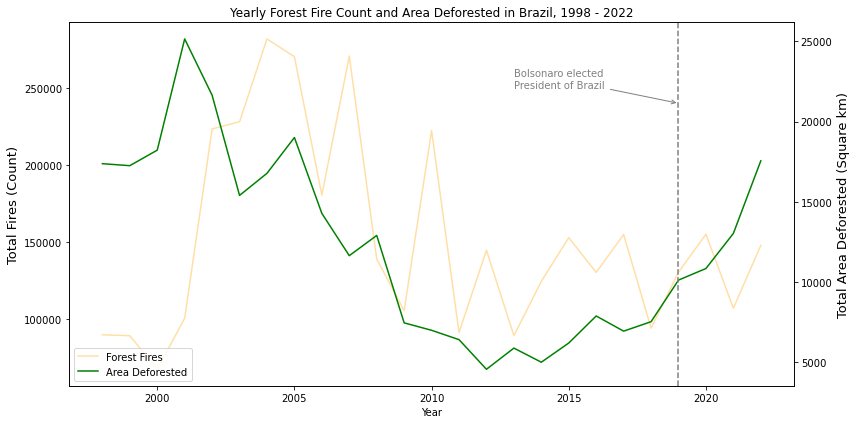

In [580]:
import matplotlib.pyplot as plt

enviro2 = environmental.reset_index().groupby('year').agg({'total_fires':'sum', 'area_deforested':'sum', 'Bolsonaro':'first'})
enviro2 = enviro2.reset_index()
enviro2.head()

fig, ax1 = plt.subplots(figsize=(12,6))

l1, = ax1.plot(enviro2["year"], enviro2["total_fires"], color='orange', alpha=0.35)
ax1.set_ylabel("Total Fires (Count)", fontsize=13)
ax1.set_xlabel("Year")
ax2=ax1.twinx()
l2, = ax2.plot(enviro2["year"], enviro2["area_deforested"], color='green')
ax2.set_ylabel("Total Area Deforested (Square km)", fontsize =13)

plt.legend([l1, l2], ["Forest Fires", "Area Deforested"])
plt.axvline(x = 2019, color = 'grey', linestyle='dashed')
ax1.annotate("Bolsonaro elected \nPresident of Brazil", xy=(2019, 240000), xytext=(2013, 250000), color='grey',
           arrowprops=dict(arrowstyle="->", color='grey'),
           ) 
plt.title("Yearly Forest Fire Count and Area Deforested in Brazil, 1998 - 2022")
fig.tight_layout()
plt.show()

### Visualizations - Part B

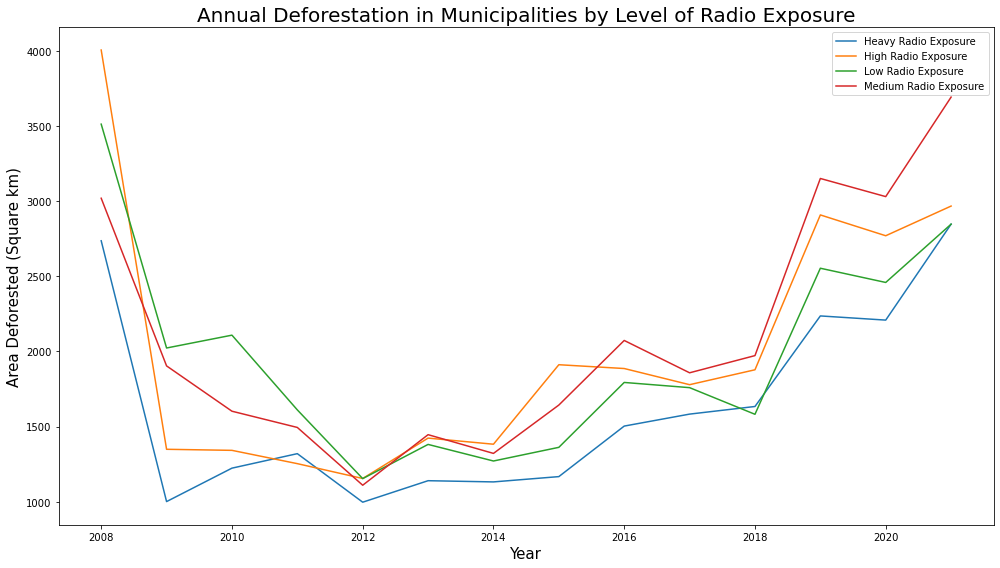

In [505]:
radio_rate_level = total2.copy()
radio_rate_level = pd.DataFrame(radio_rate_level)

def radio_level(s):
    if s < 51.2:
        s = "low"
    elif s < 59.18:
        s = "medium"
    elif s < 66.637744:
        s = "heavy"
    elif s < 100:
        s = "high"
    else:
        s = "NaN"
    return s

radio_rate_level["radio_level"] = radio_rate_level["radio_rate"].apply(radio_level)
radio_rate_level = radio_rate_level[["year", "area_int", "radio_level"]].groupby(['year', 'radio_level']).agg({'area_int':'sum'})

fig, ax = plt.subplots(figsize=(14,8))
radio_rate_level.unstack().plot(ax=ax)
ax.legend(["Heavy Radio Exposure", "High Radio Exposure", "Low Radio Exposure", "Medium Radio Exposure"])
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Area Deforested (Square km)", fontsize=15)
ax.set_title("Annual Deforestation in Municipalities by Level of Radio Exposure", fontsize=20)
fig.tight_layout()

### Visualizations - Part C (Maps in R)

***Please see attached documents that highlight the code and maps made in R***

# Part 4 - Regression

In [576]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from statsmodels.iolib.summary2 import summary_col

#import pandas_datareader.data as web

from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)

import matplotlib.pyplot as plt
%matplotlib inline

## Model: Fixed Effect Panel Regression

In [574]:
FE_ols = smf.ols(formula="area_int ~ 1 + Bolsonaro + radio_rate + Bolsonaro*radio_rate + C(geo_code) + state_year" , data = full_total).fit()

print(FE_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               area_int   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     27.58
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:27:59   Log-Likelihood:                -34255.
No. Observations:                7691   AIC:                         7.002e+04
Df Residuals:                    6935   BIC:                         7.527e+04
Df Model:                         755                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

# Part 5 - Conclusion



Our regression model in Part 4 provides a solid starting point to fitting a model to the day to predict reforestation rates based on President Bolsonaro's election and municipalitie's radio penetration. With the use of municipal and state-year fixed effects, we attempted to control for mny micro-level unobersvale characteristics. 

The R-squared value of ~0.75 suggest strong fit. The coefficient on Bolsonaro's election indicator is positive, but it is not significant. The coefficient on radio_rate is negative and is slightly significant with a P-value of 0.06. 

From our visualizations above, we know that deforestation trends were already heading upwards which may help explain the lack of significance from Bolsonaro's election.